In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

In [2]:
%matplotlib notebook

In [3]:

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


# Set responsivity params

In [5]:
responsive_test = 'nstds'
responsive_thr = 10.0
n_stds = 2.5


# Get aggregated data

In [6]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
trace_type = optsE.trace_type
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_inst

In [7]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
dsets = sdata[sdata['experiment']=='blobs']

In [8]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


# Create output dir for classification

In [9]:
outdir = os.path.join(aggregate_dir, 'blob-classification', stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00


In [10]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [121]:
# Set plotting params
threshold_dff = True
min_dff = 0.03
cmap = 'inferno'
n_sz = 5
n_mp = 10

tune_name='morph'

incorrect_nvalues = []


In [122]:
reload(util)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_ins

<module 'pipeline.python.classifications.experiment_classes' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.pyc'>

# Test 1 dataset

In [123]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC117' #'JC059'
session = '20191105' #'20190227'
visual_area = 'Li'

fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


In [124]:
threshold_dff = True

data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

n_sizes = len(sdf['size'].unique())
n_morphs = len(sdf['morphlevel'].unique()) 
if n_sizes != n_sz or n_morphs != n_mp:
    incorrect_nvalues.append(skey)
    pass

rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                             response_type=response_type, responsive_test=responsive_test,
                             responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

# Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T

# Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

#stimdf = sdf[sdf['morphlevel'] != -1]

... [JC117|20191105|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 41 of 82 responsive cells.


<IPython.core.display.Javascript object>


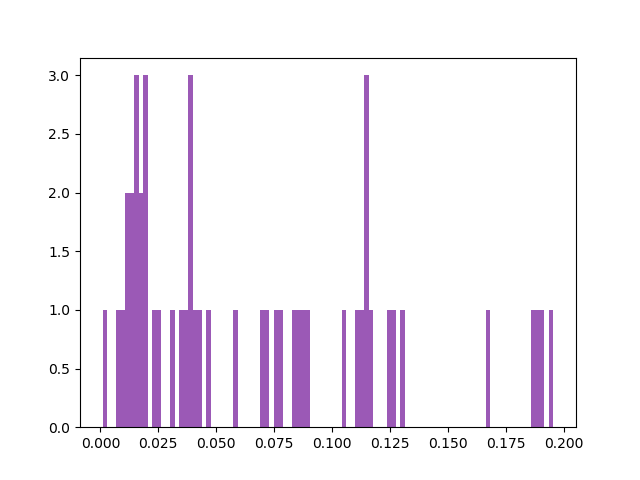

0.1956204784534491


In [137]:
vs = estats.gdf.get_group(18).groupby('config').mean()['dff']
pl.figure()
pl.hist(vs, bins=100)
print vs.max()

<IPython.core.display.Javascript object>


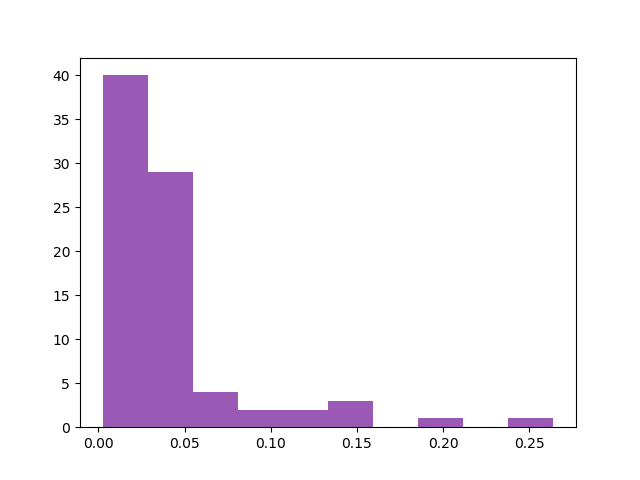

(array([40., 29.,  4.,  2.,  2.,  3.,  0.,  1.,  0.,  1.]),
 array([0.0023809 , 0.02855469, 0.05472848, 0.08090226, 0.10707605,
        0.13324984, 0.15942363, 0.18559742, 0.2117712 , 0.23794499,
        0.26411878]),
 <a list of 10 Patch objects>)

In [134]:
pl.figure()
pl.hist([g.groupby('config').mean()['dff'].max() for r, g in estats.gdf])

In [128]:

sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                      index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
sample_data = sample_data[rois_plot]
sample_labels = np.array(sample_data.index.tolist())

sdf = exp.data.sdf.copy()
sdf = reformat_morph_values(sdf)

#stimdf = sdf[sdf['morphlevel'] != -1]
stimdf = sdf.copy()
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())

#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [0, 106]
restrict_transform = True
constant_transform = 'size'

C = 1e3
m0 = 0
m100 = 106
#fig, ax = pl.subplots()

size_colors = sns.cubehelix_palette(len(tested_sizes))
lw=2


In [129]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00'

<IPython.core.display.Javascript object>


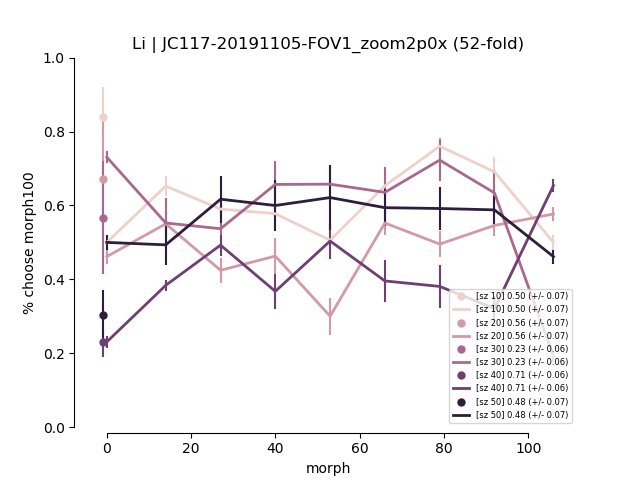

... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 41 of 82 responsive cells.
mean score: 0.50 (+/- 0.07)
mean score: 0.56 (+/- 0.07)
mean score: 0.23 (+/- 0.06)
mean score: 0.71 (+/- 0.06)
mean score: 0.48 (+/- 0.07)
Li_JC117-20191105-FOV1_zoom2p0x_AvsB-linearSVM-LOO


In [131]:

fig, ax = pl.subplots()
fig.patch.set_alpha(1)

skey = '-'.join([animalid, session, fov])
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

trace_desc = '%s_%s-%s' % (skey, traceid, trace_type)
#tfilename = os.path.join(aggr_tcourse_dir, '%s_%s.pkl' % (visual_area, trace_desc))
#print("Timecourse: %s" % os.path.split(tfilename)[-1])
#
load_data=True
sdf = reformat_morph_values(sdf)

# Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)

meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T

# Get ROI list
min_dff=0.03
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) >= min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                      index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
sample_data = sample_data[rois_plot]
sample_labels = np.array(sample_data.index.tolist())
stimdf = sdf.copy()

#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [0, 106]
restrict_transform = True
constant_transform = 'size'

C = 1e3
m0 = 0
m100 = 106

size_colors = sns.cubehelix_palette(len(tested_sizes))
lw=2
pdict = dict()
for curr_sz, curr_color in zip(tested_sizes, size_colors):

    if restrict_transform:
        constant_transform_val = curr_sz
        train_configs = stimdf[((stimdf[class_name].isin(class_types)) & (stimdf[constant_transform]==constant_transform_val))].index.tolist()
    else:
        train_configs = stimdf[stimdf[class_name].isin(class_types)].index.tolist()

    # Set train/test set:
    train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

    X = sample_data.iloc[train_ixs].values #[train_configs]
    y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

    # Set validation set:
    untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
    test_configs = stimdf[( (stimdf[constant_transform]==constant_transform_val) & (stimdf[class_name].isin(untrained_class_types)) )].index.tolist()
    test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
    X_test = sample_data.iloc[test_ixs].values
    y_test_labels = sample_labels[test_ixs]


    #% Train/test split
    n_splits = len(X)

    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X)

    scores=[]
    test_scores = dict((stimdf[class_name][tc], []) for tc in test_configs)
    choices = dict((tc, []) for tc in tested_morphs)

    for train_index, validate_index in kf.split(X):
        # Get current train/test split data:
        X_train, X_validate = X[train_index], X[validate_index]
        y_train, y_validate = y[train_index], y[validate_index]
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)

        # Fit SVM:
        trained_svc = LinearSVC(multi_class='ovr', C=C).fit(X_train_transformed, y_train)

        # Test:
        X_validate_transformed = scaler.transform(X_validate)
        curr_score = trained_svc.score(X_validate_transformed, y_validate)  
        y_pred = trained_svc.predict(X_validate_transformed)

        # Test 2:
        for true_val, pred_val in zip(y_validate, y_pred):
            choices[true_val].append(pred_val)

        for tc in test_configs:
            X_test_transformed = scaler.transform(X_test[np.where(y_test_labels==tc)[0], :])
            curr_score_test = trained_svc.score(X_test_transformed, [m100 for _ in range(X_test_transformed.shape[0])])  
            test_scores[stimdf[class_name][tc]].append(curr_score_test)
            y_pred_test = trained_svc.predict(X_test_transformed)

            choices[stimdf[class_name][tc]].append(y_pred_test)

        scores.append(curr_score)

    print("mean score: %.2f (+/- %.2f)" % (np.mean(scores), spstats.sem(scores)))
    #for k, v in sorted(test_scores.items(), key=lambda x: x[0]):
    #    print k, np.nanmean(v)

    #fig, ax = pl.subplots()
    pchoose100={}
    pchoose100_sem={}
    for k, v in choices.items():
        if k in [m0, m100]:
            pchoose100[k] = np.mean(np.sum([i==m100 for i in v]) / float(len(v)))
            pchoose100_sem[k] = np.std([i==m100 for i in v]) / float(len(v))
        else:
            pchoose100[k] = np.mean([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])
            pchoose100_sem[k] = np.std([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])

    curr_label = "[sz %i] %.2f (+/- %.2f)" % (curr_sz, np.mean(scores), spstats.sem(scores))
    for cax in [ax]: # ax2]:
        if -1 in pchoose100.keys():
            cax.plot(sorted(pchoose100.keys())[0], [pchoose100[k] for k in sorted(pchoose100.keys())][0], 'o', \
                markersize=5, lw=lw, color=curr_color, label=curr_label)
            cax.errorbar(sorted(pchoose100.keys())[0], [pchoose100[k] for k in sorted(pchoose100.keys())][0],\
                    yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())][0], fmt='none',
                    ecolor=curr_color)

            cax.plot(sorted(pchoose100.keys())[1:], [pchoose100[k] for k in sorted(pchoose100.keys())][1:], '-', \
                    markersize=.5, lw=lw, color=curr_color, label=curr_label)
            cax.errorbar(sorted(pchoose100.keys())[1:], [pchoose100[k] for k in sorted(pchoose100.keys())][1:],\
                        yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())][1:], fmt='none',
                        ecolor=curr_color)
        else:
            cax.plot(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())], '-', \
                    markersize=.5, lw=lw, color=curr_color, label=curr_label)
            cax.errorbar(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())],\
                        yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())], fmt='none',
                        ecolor=curr_color)

        cax.set_ylim([0, 1])
        cax.set_ylabel('% choose morph100')
        cax.set_xlabel('morph')
        cax.set_title('%s | %s (%i-fold)' % (visual_area, skey, n_splits))
        sns.despine(trim=True, offset=4, ax=cax)
    pdict['size_%i' % curr_sz] = {'mean': pchoose100, 'sem': pchoose100_sem}

ax.legend(fontsize=6)

pl.figure(fig.number)
figname = '%s_%s_AvsB-linearSVM-LOO' % (visual_area, skey)
pl.savefig(os.path.join(outdir, 'sessions', '%s.png' % figname))
#pl.close()
#ai += 1
print figname


In [15]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [16]:
# The "accuracy" scoring is proportional to the number of correct
# classifications
svc = LinearSVC(multi_class='ovr', C=C) #.fit(X_train_transformed, y_train)

#n_splits = len(X)
#kf = KFold(n_splits=n_splits)
kf = StratifiedKFold(5)    
    
X = sample_data.iloc[train_ixs].values.copy() #[train_configs]
y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

rfecv = RFECV(estimator=svc, step=1, cv=kf, scoring='accuracy')
rfecv.fit(X, y)

NameError: name 'train_ixs' is not defined

In [ ]:
# Plot number of features VS. cross-validation scores
fig, ax = pl.subplots()
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)


In [18]:
visual_areas = ['V1', 'Lm', 'Li']

In [24]:
rfe_results = dict((visual_area, dict()) for visual_area in visual_areas)
for visual_area in visual_areas:
    
    sessions = dsets[ dsets['visual_area'] == visual_area ]
    n_datasets = sessions.shape[0]
    
    #thresh_str = 'thr-%.2f' % min_dff if threshold_dff else 'no-thr'
    #sfilename = os.path.join(aggr_stats_dir, '%s_%s_%s-%s.pkl' % (visual_area, experiment_type, response_type, thresh_str))
    #print("Stats: %s" % os.path.split(sfilename)[-1])


    ai = 0
    #ai = 0
    for (animalid, session, fov), g in sessions.groupby(['animalid', 'session', 'fov']):
        
        skey = '-'.join([animalid, session, fov])
            
        data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
        
        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)    
        # Get stimulus conditions
        sdf = exp.get_stimuli()
        sdf = reformat_morph_values(sdf)
        #print sdf.head()
        tested_sizes = np.array(sorted(sdf['size'].unique()))
        tested_morphs = np.array(sorted(sdf['morphlevel'].unique()))

        sdf = reformat_morph_values(sdf)        
        n_sizes = len(tested_sizes)
        n_morphs = len(tested_morphs)
        if n_sizes != n_sz or n_morphs != n_mp:
            incorrect_nvalues.append(skey)
            pass

        trace_desc = '%s_%s-%s' % (skey, traceid, trace_type)
        tfilename = os.path.join(aggr_tcourse_dir, '%s_%s.pkl' % (visual_area, trace_desc))
        print("Timecourse: %s" % os.path.split(tfilename)[-1])
        #load_data=False
        try:
            with open(tfilename, 'rb') as f:
                exp = pkl.load(f)
                assert exp.data is not None and 'traces' in dir(exp.data)
                sdf = exp.data.sdf.copy()
        except Exception as e:
            load_data = True

        sdf = reformat_morph_values(sdf)

        # Get metrics for each condition
        estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                           for roi in estats.rois], axis=1).T

        # Get ROI list
        if threshold_dff:
            rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            rois_plot = meanr.index.tolist()
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

        sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                              index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
        sample_data = sample_data[rois_plot]
        sample_labels = np.array(sample_data.index.tolist())


        #stimdf = sdf[sdf['morphlevel'] != -1]
        stimdf = sdf.copy()

        #% Specify train/test conditions:     
        class_name = 'morphlevel'
        class_types = [0, 106]
        restrict_transform = True
        constant_transform = 'size'

        C = 1e3
        m0 = 0
        m100 = 106
        #fig, ax = pl.subplots()

        size_colors = sns.cubehelix_palette(len(tested_sizes))
        lw=2

        res = []
        size_colors = sns.cubehelix_palette(len(tested_sizes))
        lw=2
        pdict = dict()
        for curr_sz, curr_color in zip(tested_sizes, size_colors):

            if restrict_transform:
                constant_transform_val = curr_sz
                train_configs = stimdf[((stimdf[class_name].isin(class_types)) & (stimdf[constant_transform]==constant_transform_val))].index.tolist()
            else:
                train_configs = stimdf[stimdf[class_name].isin(class_types)].index.tolist()

            # Set train/test set:
            train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

            X = sample_data.iloc[train_ixs].values #[train_configs]
            y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

            # The "accuracy" scoring is proportional to the number of correct
            # classifications
            svc = LinearSVC(multi_class='ovr', C=C) #.fit(X_train_transformed, y_train)

            #n_splits = len(X)
            #kf = KFold(n_splits=n_splits)
            kf = StratifiedKFold(5)    

            rfecv = RFECV(estimator=svc, step=1, cv=kf, scoring='accuracy')
            rfecv.fit(X, y)            
            
            res.append((curr_sz, rfecv.grid_scores_))
        
        rfe_results[visual_area][skey] = res

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: V1_JC076-20190420-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 163 of 175 responsive cells.
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: V1_JC076-20190501-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 168 of 189 responsive cells.
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data path

Plotting 160 of 171 responsive cells.
... [JC083|20190512|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC083-20190512-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 253 of 266 responsive cells.
... [JC083|20190517|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC083-20190517-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 132 of 133 responsive cells.
... [JC084|20190525|FOV1_zoom2p0x] creat

In [25]:
for visual_area, res in rfe_results.items():
    visual_area

In [26]:
[v.shape for k, v in scores]

NameError: name 'scores' is not defined

In [148]:
np.array([v for k, v in scores]).mean(axis=0).shape

(21,)

<IPython.core.display.Javascript object>


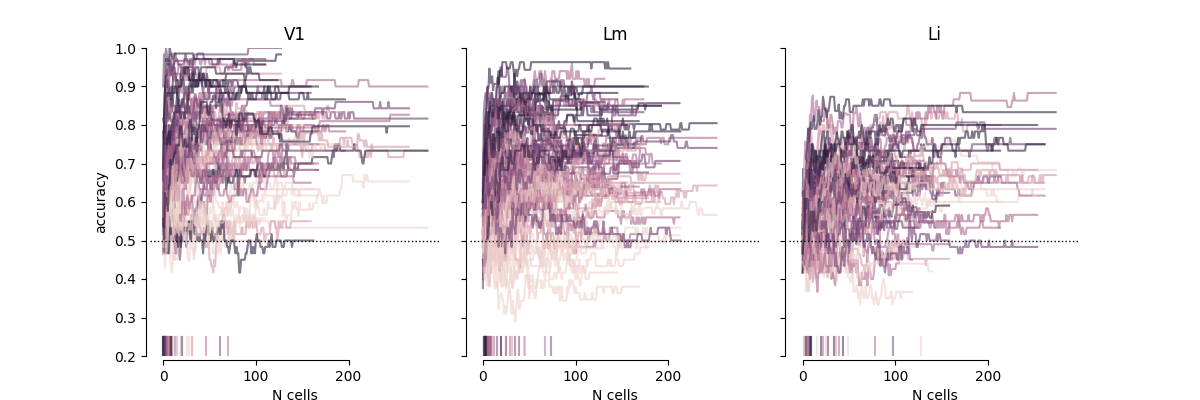

In [27]:
visual_area = 'V1'

fig, axes = pl.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, visual_area in zip(axes.flat, visual_areas):
    res = rfe_results[visual_area]

    sdict = dict((sz, []) for sz in tested_sizes)
    for skey, scores in res.items():
        for (sz, acc) in scores:
            si = list(tested_sizes).index(sz)
            sdict[sz].append(acc)
            #print skey, len(acc)
            ax.plot(range(len(acc)), acc, color=size_colors[si], alpha=0.6)

            acc_thr = np.where(acc>=0.7)[0]
            if len(acc_thr) > 0:
                acc_thr_val = int(acc_thr[0])
                ax.plot([acc_thr_val, acc_thr_val], [0, 0.25], color=size_colors[si], alpha=0.5)
        
    ax.set_title(visual_area)
    
    
for ai, ax in enumerate(axes.flat):
    ax.set_ylim([0.2, 1])
    ax.axhline(y=0.5, linestyle=':', linewidth=1, alpha=1, color='k')
    sns.despine(trim=True, offset=3)
    ax.set_xlabel('N cells')
    if ai==0:
        ax.set_ylabel('accuracy')

pl.subplots_adjust(wspace=0.1)

figname = 'RFEC-plot-each-size_linearSVM-AvsB_stratified-5-fold'
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

In [155]:
spstats.sem(np.array([v for k, v in scores]), axis=0)

array([0.02      , 0.01900292, 0.03118048, 0.04960959, 0.04960959,
       0.03045944, 0.03009245, 0.02905933, 0.0254951 , 0.02321398,
       0.02297341, 0.01870829, 0.02198484, 0.01333333, 0.01870829,
       0.02013841, 0.01699673, 0.02357023, 0.02818589, 0.0227303 ,
       0.02134375, 0.0214735 , 0.02614065, 0.02013841, 0.0254951 ,
       0.03778595, 0.02392117, 0.03100179, 0.0335824 , 0.03551213,
       0.03763863, 0.03391165, 0.03265986, 0.02635231, 0.01929306,
       0.0254951 , 0.02108185, 0.0265623 , 0.02472066, 0.03045944,
       0.03231787, 0.03374743, 0.03045944, 0.03519785, 0.02581989,
       0.02718251, 0.03009245, 0.0335824 , 0.02953341, 0.02013841,
       0.02013841, 0.02738613, 0.01943651, 0.02198484, 0.02      ,
       0.02041241, 0.02333333, 0.02013841, 0.01900292, 0.01900292,
       0.02581989, 0.0214735 , 0.01870829, 0.01615893, 0.01178511,
       0.01      , 0.01527525, 0.01825742, 0.02134375, 0.01394433,
       0.01130388, 0.01929306, 0.01748015, 0.01545603, 0.02068

<IPython.core.display.Javascript object>


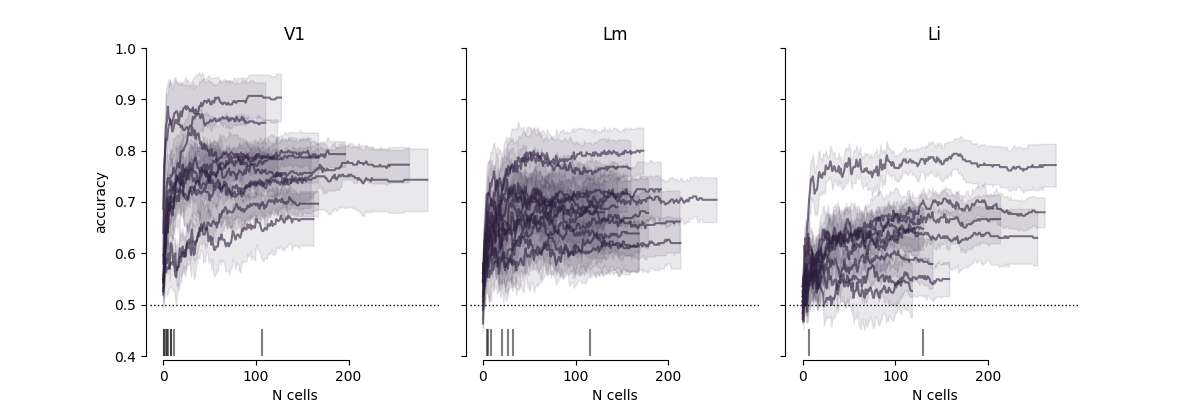

In [28]:
visual_area = 'V1'

fig, axes = pl.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, visual_area in zip(axes.flat, visual_areas):
    res = rfe_results[visual_area]

    for skey, scores in res.items():
        mean_score = np.array([v for k, v in scores]).mean(axis=0)
        sem_score = spstats.sem(np.array([v for k, v in scores]), axis=0)
        ax.plot(range(len(mean_score)), mean_score, color=size_colors[si], alpha=0.6)
        ax.fill_between(range(len(mean_score)), mean_score+sem_score,
                        mean_score-sem_score, color=size_colors[si], alpha=0.1)
        
        acc_thr = np.where(mean_score>=0.7)[0]
        if len(acc_thr) > 0:
            acc_thr_val = int(acc_thr[0])
            ax.plot([acc_thr_val, acc_thr_val], [0, 0.45], color='k', alpha=0.5)
        
    ax.set_title(visual_area)
    
for ai, ax in enumerate(axes.flat):
    ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, linestyle=':', linewidth=1, alpha=1, color='k')
    sns.despine(trim=True, offset=3)
    ax.set_xlabel('N cells')
    if ai==0:
        ax.set_ylabel('accuracy')

pl.subplots_adjust(wspace=0.1)

figname = 'RFEC-average-across-size_linearSVM-AvsB_stratified-5-fold'
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

In [29]:
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

In [164]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00'

<IPython.core.display.Javascript object>


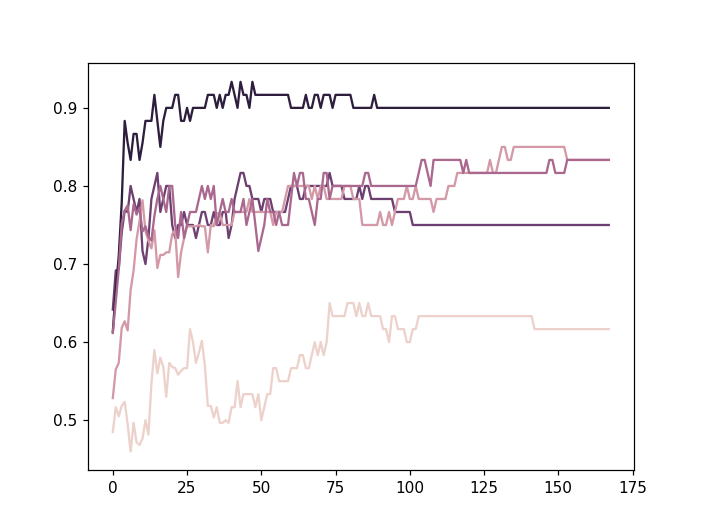

In [133]:
fig, ax = pl.subplots()
for sz, arrl in sdict.items():
    sdict[sz] = np.array(arrl) # n_datasets x n_rois
    si = list(tested_sizes).index(sz)
    nr = sdict[sz].shape[-1]
    mean_scores =  sdict[sz].mean(axis=0)
    sem_scores = sdict[sz].std(axis=0)
    
    ax.plot(range(nr), mean_scores, color=size_colors[si])
    #ax.fill_between(range(nr), sdict[sz].mean(axis=0), color=size_colors[si])

(168,)

In [30]:
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())

In [31]:
print tested_sizes

[10.0, 20.0, 30.0, 40.0, 50.0]


In [32]:
print tested_morphs

[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]


In [122]:
size_colors

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
 [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
 [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [15]:
if not os.path.exists(os.path.join(outdir, 'sessions')):
    os.makedirs(os.path.join(outdir, 'sessions'))
print(os.path.join(outdir, 'sessions'))

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/sessions


# Get aggregate stats

In [20]:
experiment_type = 'blobs'
aggr_tcourse_dir = os.path.join(aggregate_dir, 'data-stats', 'experiment-objects', experiment_type)
aggr_stats_dir = os.path.join(aggregate_dir, 'data-stats', stats_desc)

if not os.path.exists(aggr_tcourse_dir):
    os.makedirs(aggr_tcourse_dir)
if not os.path.exists(aggr_stats_dir):
    os.makedirs(aggr_stats_dir)

In [21]:
visual_areas = ['V1', 'Lm', 'Li']

In [22]:
tested_morphs

array([ -1,   0,  14,  27,  40,  53,  66,  79,  92, 106])

In [23]:
stimdf

color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
config006                0  Blob_N1  10.0    image    20    -8    0
config007                0  Blob_N1  20.0    image    20    -8    0
config008                0  Blob_N1  30.0    image    20    -8    0
config009                0  Blob_N1  40.0    image    20    -8    0
config010                0  Blob_N1  50.0    image    20    -8    0
config011               14  morph14  10.0    image    20    -8    0
config012               14  morph14  20.0    image    20    -8    0
config013               14  morph14  30.0    image    20    -8    0
config014               14  morph14  40.0    image    20    -8    0
config015               14  morph14  50.0    image    20    -8    0
config016               27  morph27  10.0    image    20    -8    0
config017               27  morph27  20.0    image    20    -8    0
config018               27  morph27  30.0    image    20    -8    0
config019               27  morph27  40.0    image    20    -8    0
config020               27  morph27  50.0    image    20    -8    0
config021               40  morph40  10.0    image    20    -8    0
config022               40  morph40  20.0    image    20    -8    0
config023               40  morph40  30.0    image    20    -8    0
config024               40  morph40  40.0    image    20    -8    0
config025               40  morph40  50.0    image    20    -8    0
config026               53  morph53  10.0    image    20    -8    0
config027               53  morph53  20.0    image    20    -8    0
config028               53  morph53  30.0    image    20    -8    0
config029               53  morph53  40.0    image    20    -8    0
config030               53  morph53  50.0    image    20    -8    0
config031               66  morph66  10.0    image    20    -8    0
config032               66  morph66  20.0    image    20    -8    0
config033               66  morph66  30.0    image    20    -8    0
config034               66  morph66  40.0    image    20    -8    0
config035               66  morph66  50.0    image    20    -8    0
config036               79  morph79  10.0    image    20    -8    0
config037               79  morph79  20.0    image    20    -8    0
config038               79  morph79  30.0    image    20    -8    0
config039               79  morph79  40.0    image    20    -8    0
config040               79  morph79  50.0    image    20    -8    0
config041               92  morph92  10.0    image    20    -8    0
config042               92  morph92  20.0    image    20    -8    0
config043               92  morph92  30.0    image    20    -8    0
config044               92  morph92  40.0    image    20    -8    0
config045               92  morph92  50.0    image    20    -8    0
config046              106  Blob_N2  10.0    image    20    -8    0
config047              106  Blob_N2  20.0    image    20    -8    0
config048              106  Blob_N2  30.0    image    20    -8    0
config049              106  Blob_N2  40.0    image    20    -8    0
config050              106  Blob_N2  50.0    image    20    -8    0

# Classify morphs LOO at each size

Stats: V1_blobs_dff-thr-0.03.pkl
['JC076-20190501-FOV1_zoom2p0x', 'JC084-20190522-FOV1_zoom2p0x', 'JC097-20190616-FOV1_zoom2p0x', 'JC097-20190613-FOV1_zoom2p0x', 'JC083-20190507-FOV1_zoom2p0x', 'JC083-20190511-FOV1_zoom2p0x', 'JC076-20190420-FOV1_zoom2p0x', 'JC083-20190510-FOV1_zoom2p0x', 'JC085-20190622-FOV1_zoom2p0x', 'JC097-20190617-FOV1_zoom2p0x']


<IPython.core.display.Javascript object>


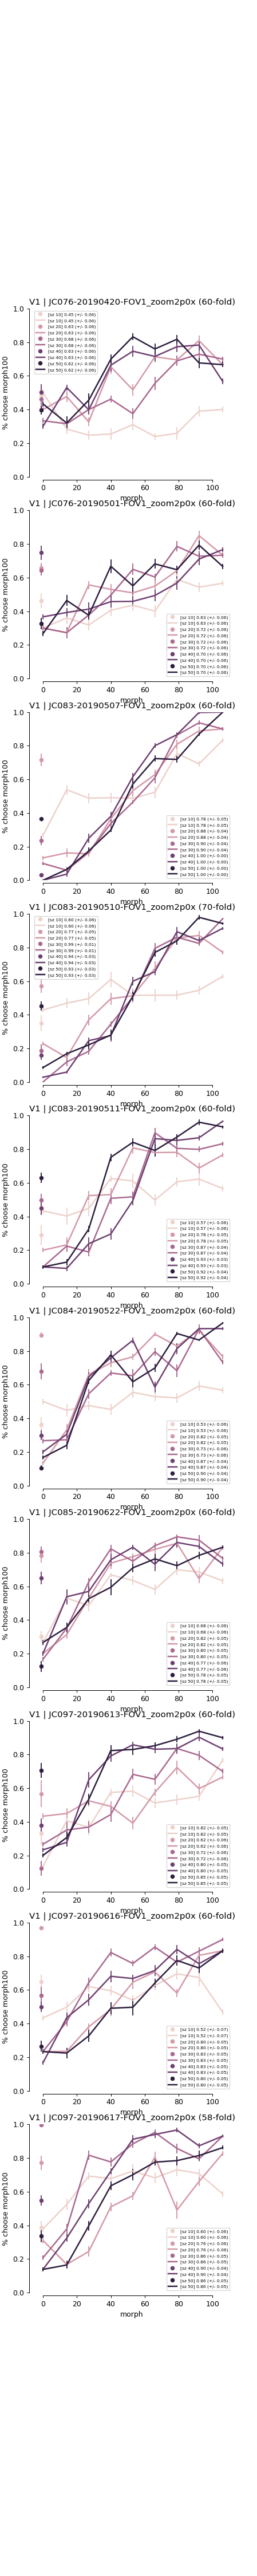

<IPython.core.display.Javascript object>


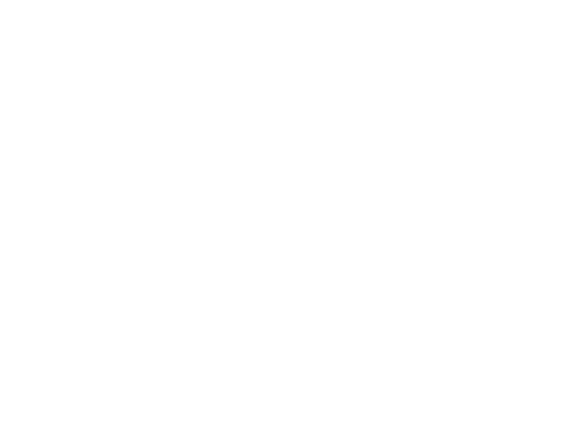

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC076-20190420-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


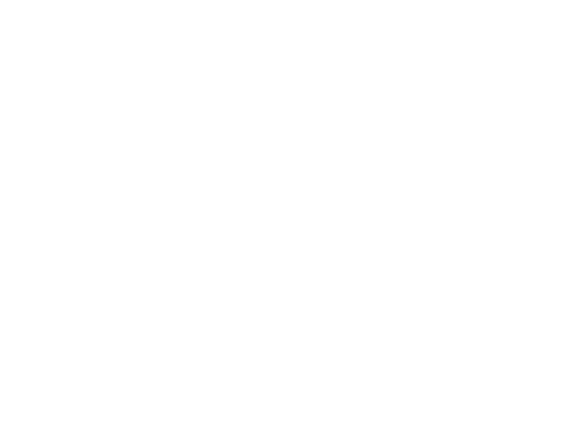

... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC076-20190501-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8bada5_traces001_f32281_traces001_8843f0_traces001_8c6f4b_traces001_62f205_traces001_185b69/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


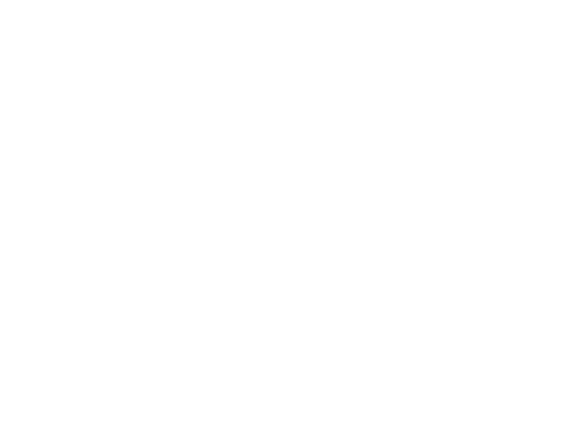

... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC083-20190507-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


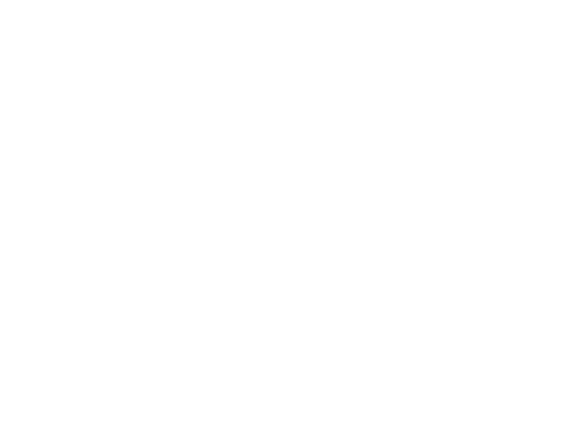

... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC083-20190510-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/data_arrays/np_subtracted.npz
adding NP 

<IPython.core.display.Javascript object>


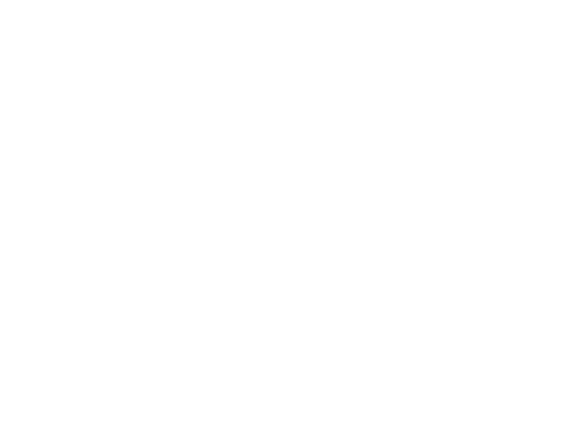

... [JC083|20190511|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC083-20190511-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_95dedb_traces001_e403bc_traces001_78845b_traces001_045759_traces001_e7bfd6_traces001_c43fca/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


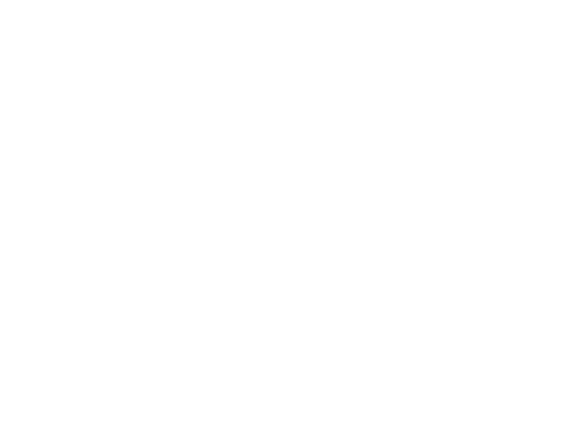

... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC084-20190522-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


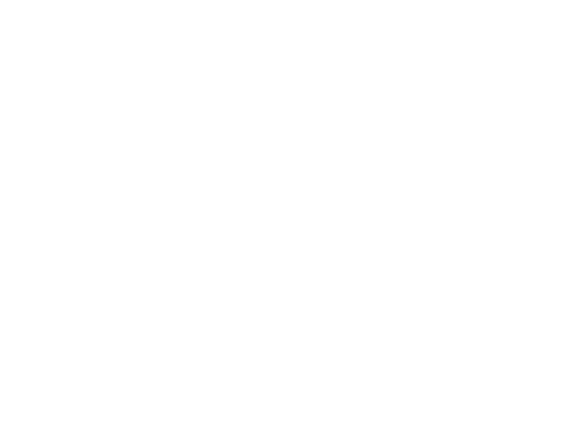

... [JC085|20190622|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC085-20190622-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_traces001_6537ce/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


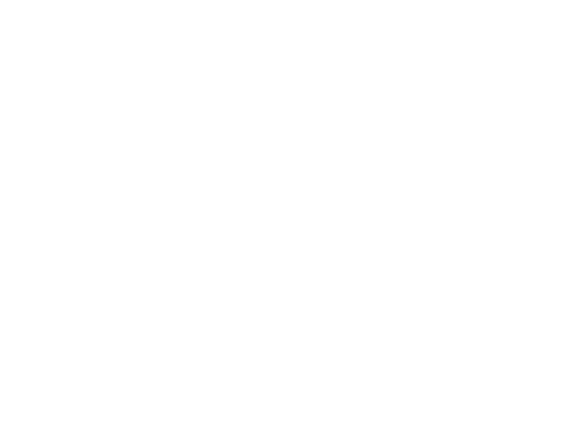

... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC097-20190613-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_b92766_traces001_02482e_traces001_b1d533_traces001_f15eef_traces001_ccd355_traces001_b8ae95/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


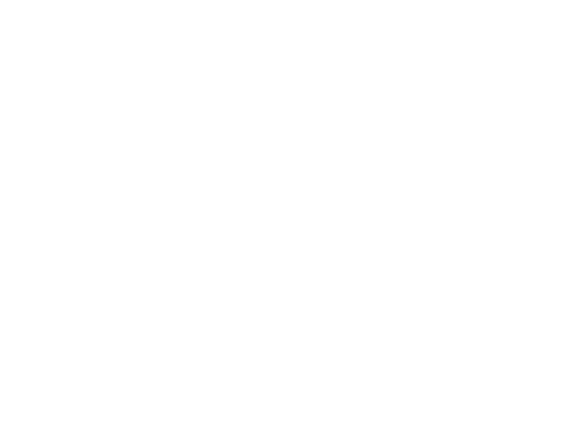

... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC097-20190616-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


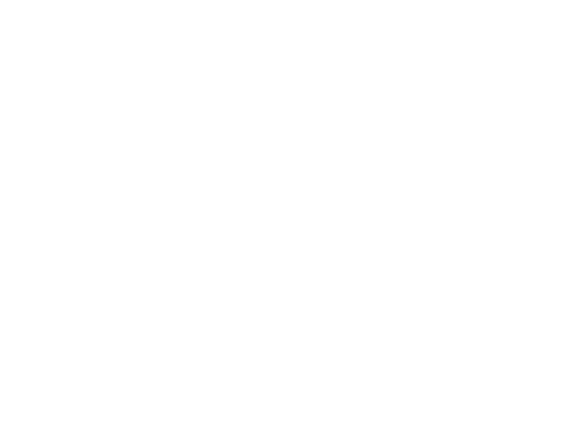

... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC097-20190617-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/data_arrays/np_subtracted.npz
adding NP offset...
... adj

<IPython.core.display.Javascript object>


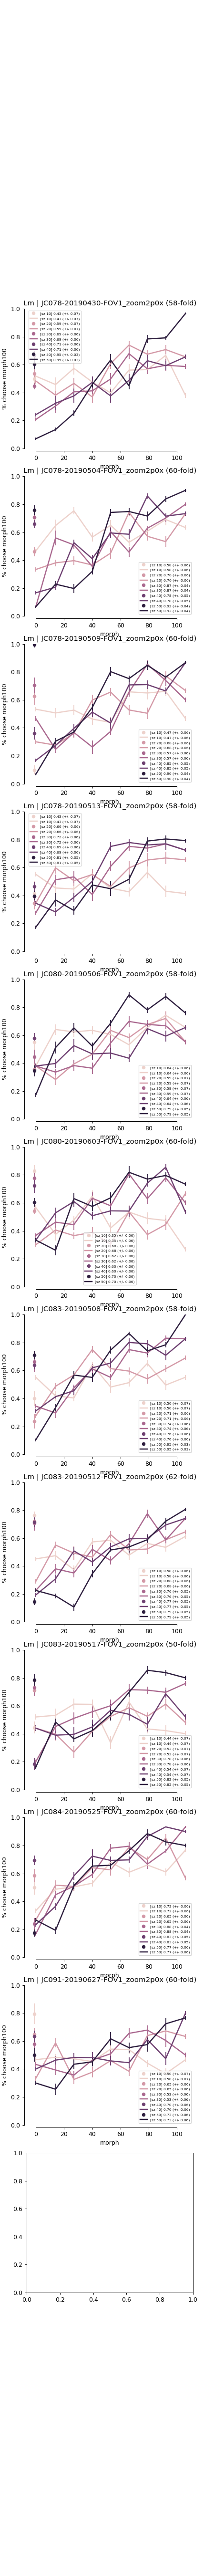

<IPython.core.display.Javascript object>


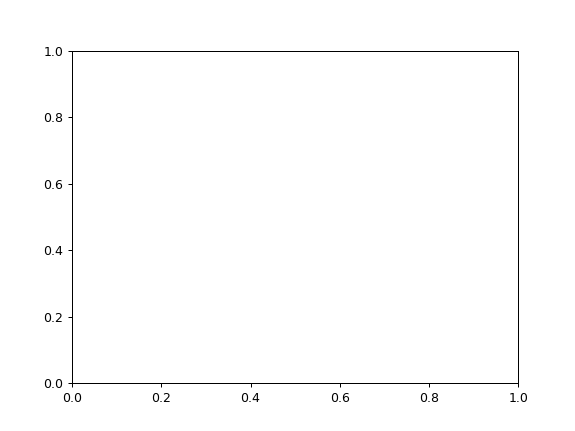

<IPython.core.display.Javascript object>


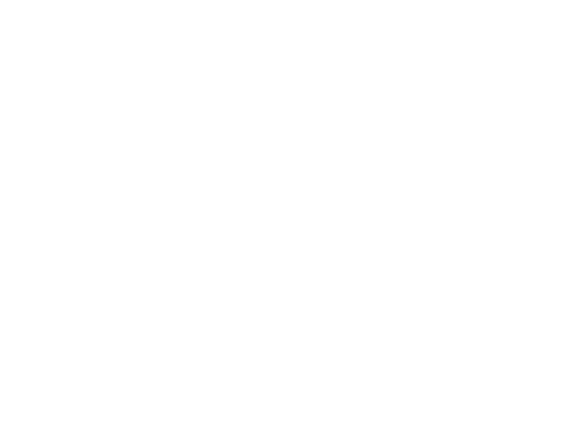

... [JC078|20190430|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190430-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dfb5b6_traces001_929bd6_traces001_383b98_traces001_e649db_traces001_9a1a48_traces001_f5276a/data_arrays/np_subtracted.npz
adding NP offset...
... adj

<IPython.core.display.Javascript object>


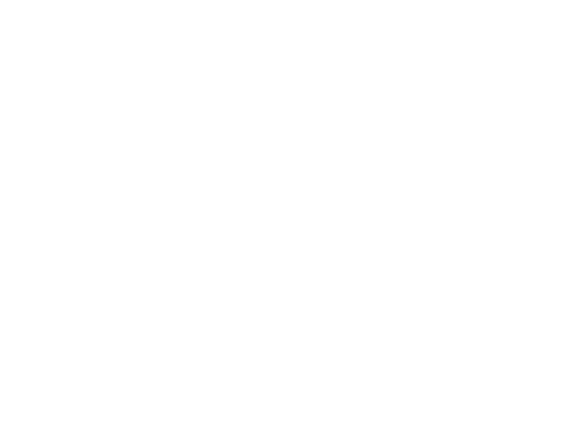

... [JC078|20190504|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190504-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_830af1_traces001_241385_traces001_4f577b_traces001_8a5bd2_traces001_af220b_traces001_f47906/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


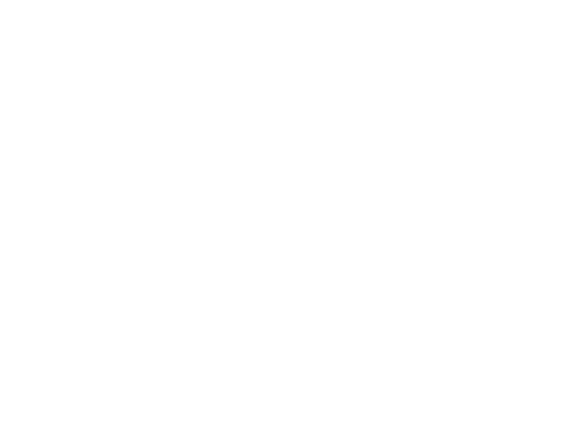

... [JC078|20190509|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190509-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC078/20190509/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d242e7_traces001_37b7c0_traces001_dcf502_traces001_50495c_traces001_b5b103_traces001_31048d/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


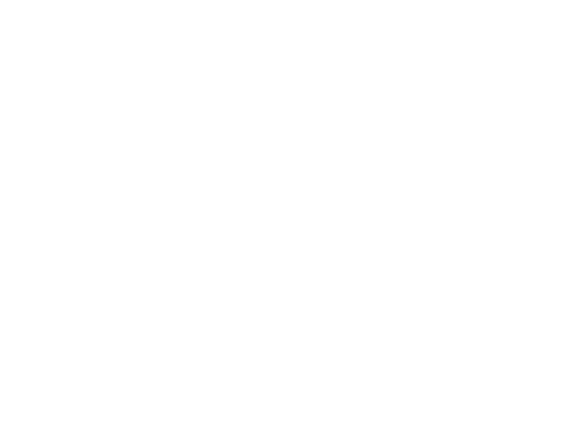

... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190513-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_23404b_traces001_f36dbe_traces001_ece5a1_traces001_c7edbd_traces001_ba61ae_traces001_1ef319/data_arrays/np_subtracted.npz
adding NP offset...
... adj

<IPython.core.display.Javascript object>


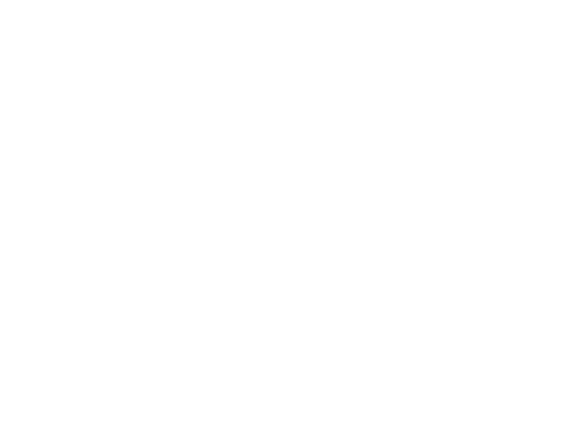

... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC080-20190506-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8a95b0_traces001_ba1965_traces001_f4a730_traces001_77eafa_traces001_78a718_traces001_e4c65e/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


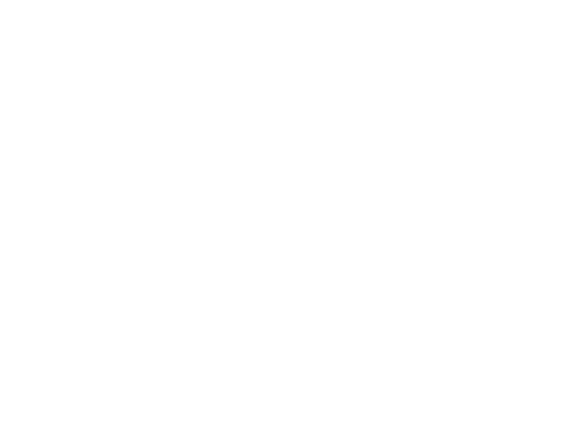

... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC080-20190603-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_e17055_traces001_dd9e99_traces001_841aa9_traces001_d4242f_traces001_7b3713_traces001_d4ccf3/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


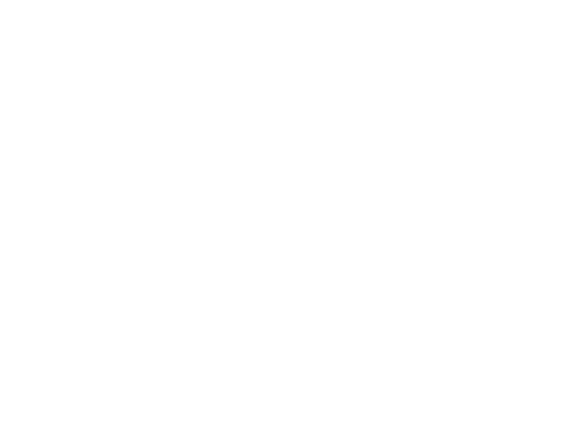

... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC083-20190508-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/data_arrays/np_subtracted.npz
adding NP offset...
... adj

<IPython.core.display.Javascript object>


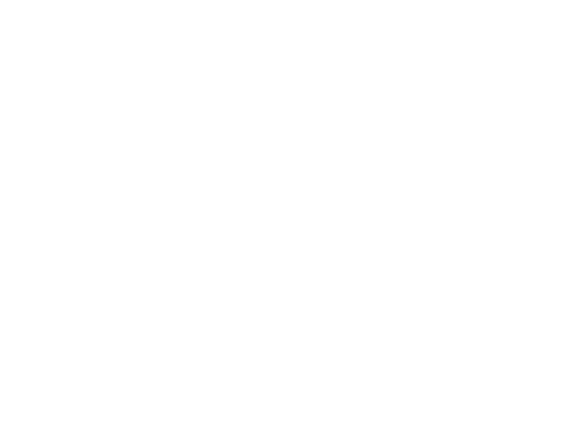

... [JC083|20190512|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC083-20190512-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_cb9ce5_traces001_fad0ce_traces001_cdd5f2_traces001_7e3617_traces001_e45519_traces001_4ad203_traces001_8117b2/data_arrays/np_subtracted.npz
adding NP 

<IPython.core.display.Javascript object>


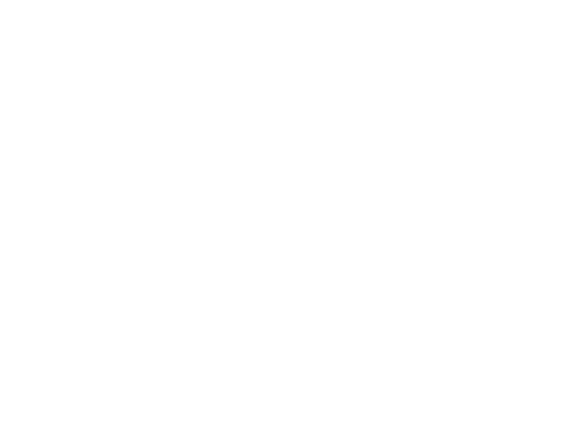

... [JC083|20190517|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC083-20190517-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0c1b62_traces001_654830_traces001_c16392_traces001_266bc9_traces001_0b327f/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filter

<IPython.core.display.Javascript object>


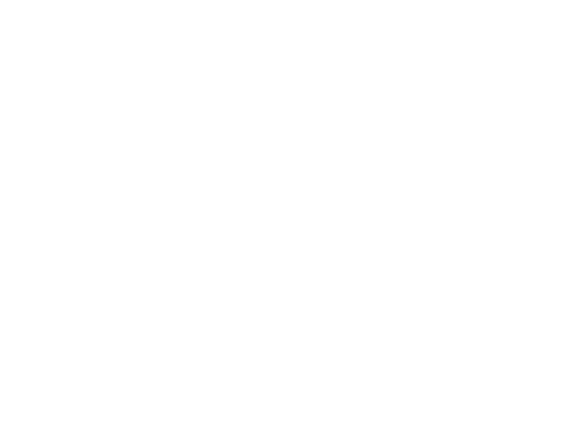

... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC084-20190525-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dea723_traces001_8cef6c_traces001_abf256_traces001_fb7bfa_traces001_452942_traces001_c0afbd/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


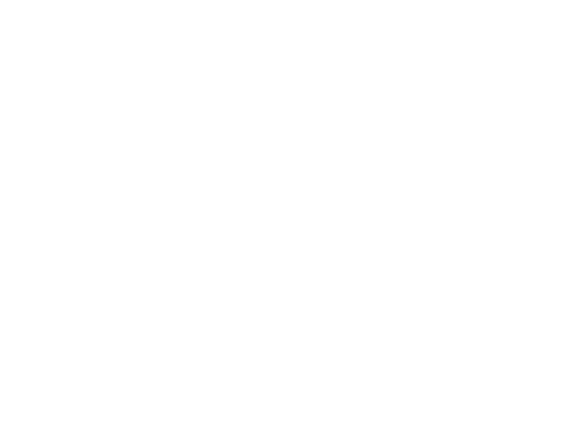

... [JC091|20190627|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC091-20190627-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_99ce14_traces001_328664_traces001_f2e06a_traces001_26306f_traces001_7fd9a8_traces001_9f1071/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


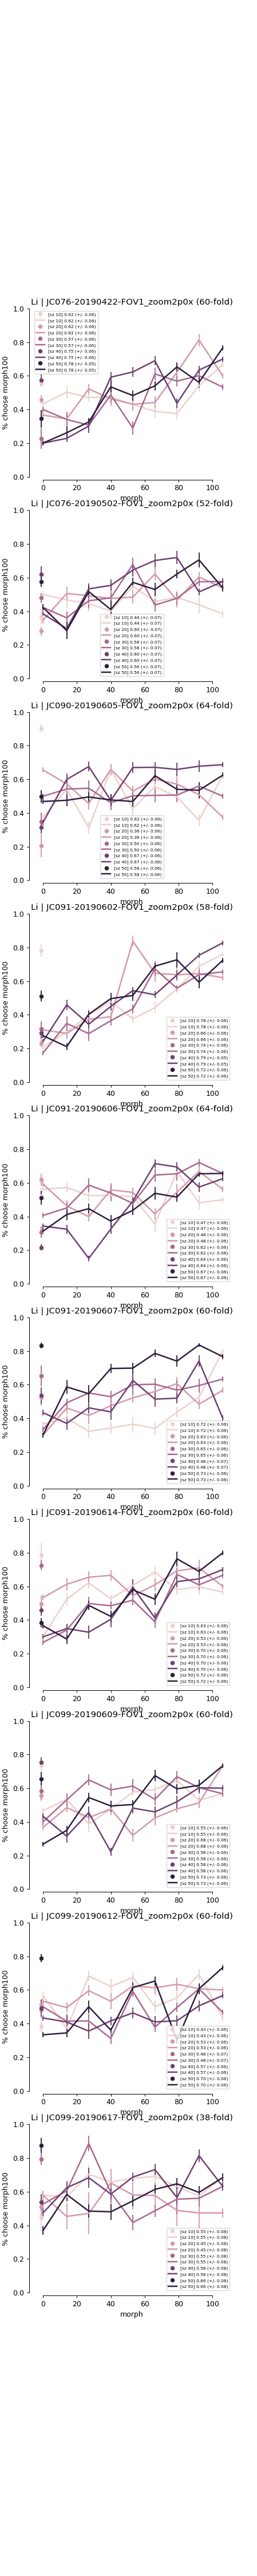

<IPython.core.display.Javascript object>


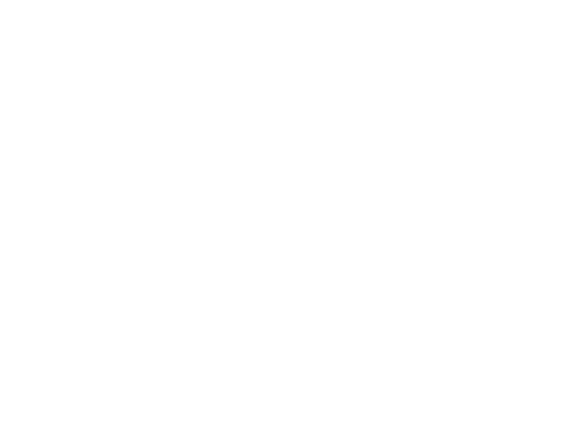

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC076-20190422-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


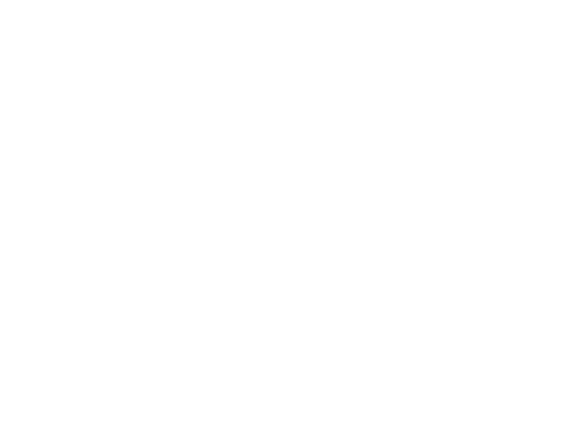

... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC076-20190502-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e62928_traces001_82b664/data_arrays/np_subtracted.npz
adding NP offset...
... adj

<IPython.core.display.Javascript object>


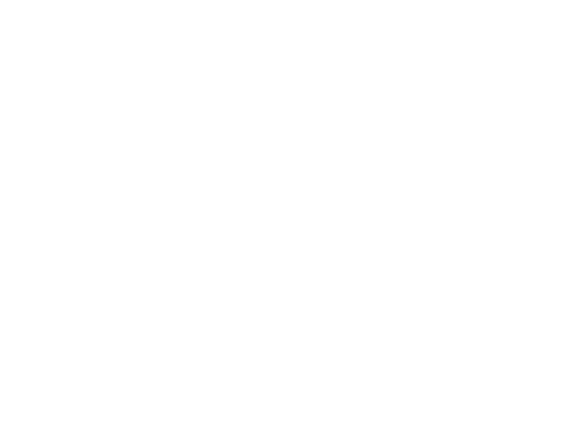

... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC090-20190605-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
adding NP 

<IPython.core.display.Javascript object>


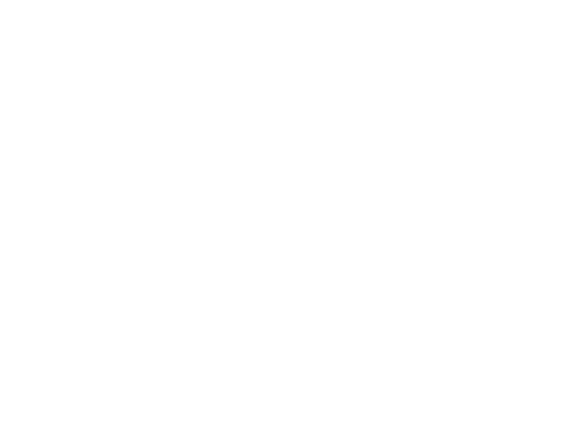

... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190602-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/data_arrays/np_subtracted.npz
adding NP offset...
... adj

<IPython.core.display.Javascript object>


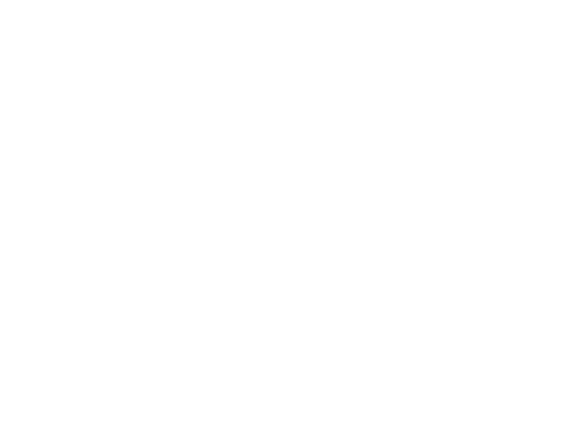

... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190606-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_c8905e_traces001_cca83f_traces001_282089_traces001_d63f40_traces001_5e8ae8_traces001_d9484e_traces001_a6f53c/data_arrays/np_subtracted.npz
adding NP 

<IPython.core.display.Javascript object>


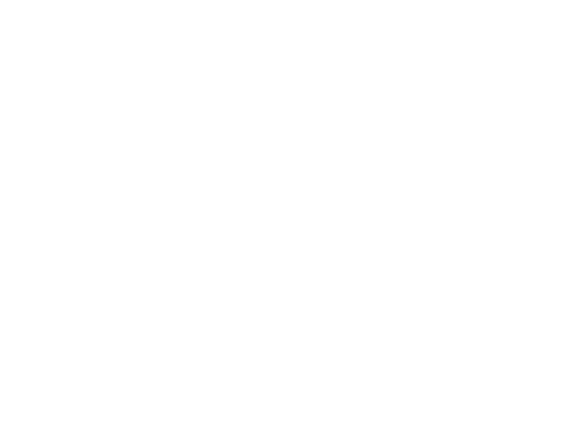

... [JC091|20190607|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190607-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


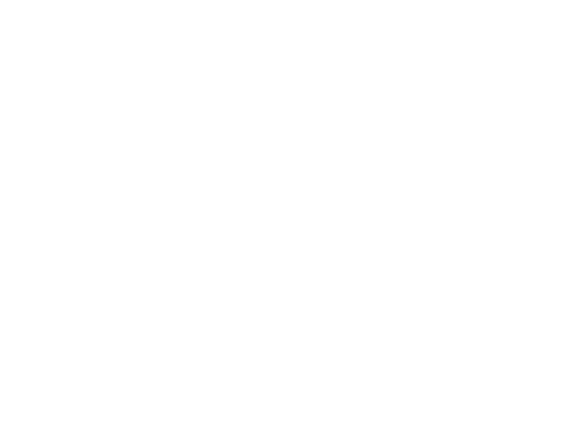

... [JC091|20190614|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190614-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_traces001_7c7a76_traces001_cc90dc_traces001_344475/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


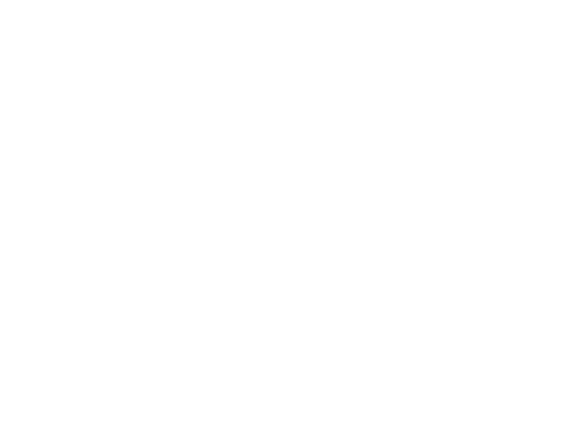

... [JC099|20190609|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC099-20190609-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_traces001_0b8503_traces001_2d8e76_traces001_8fe19c/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


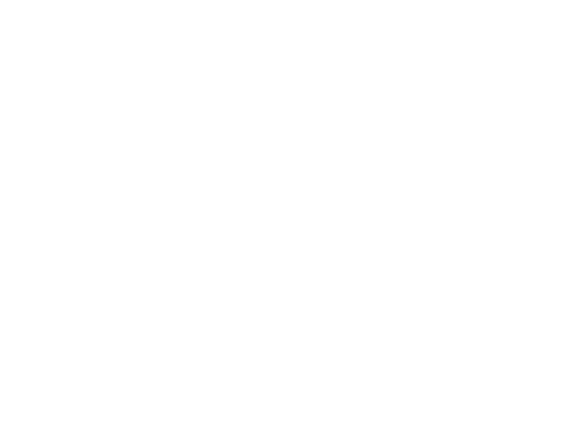

... [JC099|20190612|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC099-20190612-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d86de1_traces001_8df9ce_traces001_61ca30_traces001_0266b8_traces001_111679_traces001_0abebe/data_arrays/np_subtracted.npz
adding NP offset...
... upd

<IPython.core.display.Javascript object>


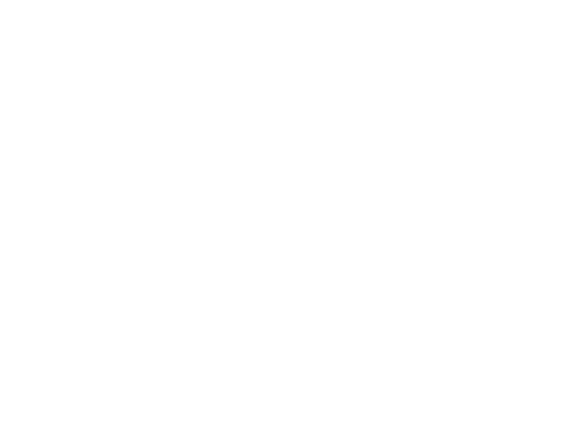

... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC099-20190617-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_94cb73_traces001_9d8a71_traces001_7a514c_traces001_864da3/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
.

In [47]:
results = dict((visual_area, dict()) for visual_area in visual_areas)

for visual_area in visual_areas:
    
    sessions = dsets[ dsets['visual_area'] == visual_area ]
    n_datasets = sessions.shape[0]
    
    thresh_str = 'thr-%.2f' % min_dff if threshold_dff else 'no-thr'
    sfilename = os.path.join(aggr_stats_dir, '%s_%s_%s-%s.pkl' % (visual_area, experiment_type, response_type, thresh_str))
    print("Stats: %s" % os.path.split(sfilename)[-1])
    load_data=False
    try:
        with open(sfilename, 'rb') as f:
            allstats = pkl.load(f)
            #assert 'gdf' in estats
    except Exception as e:
        load_data = True
        allstats = {}
    print(allstats.keys())

    f2, axes = pl.subplots(n_datasets, figsize=(5, n_datasets*5))
    f2.patch.set_alpha(1)

    ai = 0
    #ai = 0
    for (animalid, session, fov), g in sessions.groupby(['animalid', 'session', 'fov']):
        ax2 = axes[ai]

        fig, ax = pl.subplots()
        fig.patch.set_alpha(1)

        skey = '-'.join([animalid, session, fov])
        data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
        if animalid=='JC078' and session=='20190426':
            continue
        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)    
        # Get stimulus conditions
        sdf = exp.get_stimuli()
        sdf = reformat_morph_values(sdf)
        print sdf.head()
        tested_sizes = np.array(sorted(sdf['size'].unique()))
        tested_morphs = np.array(sorted(sdf['morphlevel'].unique()))

        sdf = reformat_morph_values(sdf)        
        n_sizes = len(tested_sizes)
        n_morphs = len(tested_morphs)
        if n_sizes != n_sz or n_morphs != n_mp:
            incorrect_nvalues.append(skey)
            pass

        trace_desc = '%s_%s-%s' % (skey, traceid, trace_type)
        tfilename = os.path.join(aggr_tcourse_dir, '%s_%s.pkl' % (visual_area, trace_desc))
        print("Timecourse: %s" % os.path.split(tfilename)[-1])
        #
        load_data=True
#         try:
#             with open(tfilename, 'rb') as f:
#                 exp = pkl.load(f)
#                 assert exp.data is not None and 'traces' in dir(exp.data)
#                 sdf = exp.data.sdf.copy()
#         except Exception as e:
#             load_data = True

        sdf = reformat_morph_values(sdf)

        if load_data:
            # Get metrics for each condition
            estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
            with open(tfilename, 'wb') as f:
                pkl.dump(exp, f, protocol=pkl.HIGHEST_PROTOCOL)
            allstats[skey] = estats

        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                           for roi in estats.rois], axis=1).T

        # Get ROI list
        if threshold_dff:
            rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            rois_plot = meanr.index.tolist()
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

        sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                              index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
        sample_data = sample_data[rois_plot]
        sample_labels = np.array(sample_data.index.tolist())


        #stimdf = sdf[sdf['morphlevel'] != -1]
        stimdf = sdf.copy()
        
        #% Specify train/test conditions:     
        class_name = 'morphlevel'
        class_types = [0, 106]
        restrict_transform = True
        constant_transform = 'size'

        C = 1e3
        m0 = 0
        m100 = 106
        #fig, ax = pl.subplots()

        size_colors = sns.cubehelix_palette(len(tested_sizes))
        lw=2
        pdict = dict()
        for curr_sz, curr_color in zip(tested_sizes, size_colors):

            if restrict_transform:
                constant_transform_val = curr_sz
                train_configs = stimdf[((stimdf[class_name].isin(class_types)) & (stimdf[constant_transform]==constant_transform_val))].index.tolist()
            else:
                train_configs = stimdf[stimdf[class_name].isin(class_types)].index.tolist()

            # Set train/test set:
            train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

            X = sample_data.iloc[train_ixs].values #[train_configs]
            y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

            # Set validation set:
            untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
            test_configs = stimdf[( (stimdf[constant_transform]==constant_transform_val) & (stimdf[class_name].isin(untrained_class_types)) )].index.tolist()
            test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
            X_test = sample_data.iloc[test_ixs].values
            y_test_labels = sample_labels[test_ixs]


            #% Train/test split
            n_splits = len(X)

            kf = KFold(n_splits=n_splits)
            kf.get_n_splits(X)

            scores=[]
            test_scores = dict((stimdf[class_name][tc], []) for tc in test_configs)
            choices = dict((tc, []) for tc in tested_morphs)

            for train_index, validate_index in kf.split(X):
                # Get current train/test split data:
                X_train, X_validate = X[train_index], X[validate_index]
                y_train, y_validate = y[train_index], y[validate_index]
                scaler = preprocessing.StandardScaler().fit(X_train)
                X_train_transformed = scaler.transform(X_train)

                # Fit SVM:
                trained_svc = LinearSVC(multi_class='ovr', C=C).fit(X_train_transformed, y_train)

                # Test:
                X_validate_transformed = scaler.transform(X_validate)
                curr_score = trained_svc.score(X_validate_transformed, y_validate)  
                y_pred = trained_svc.predict(X_validate_transformed)

                # Test 2:
                for true_val, pred_val in zip(y_validate, y_pred):
                    choices[true_val].append(pred_val)

                for tc in test_configs:
                    X_test_transformed = scaler.transform(X_test[np.where(y_test_labels==tc)[0], :])
                    curr_score_test = trained_svc.score(X_test_transformed, [m100 for _ in range(X_test_transformed.shape[0])])  
                    test_scores[stimdf[class_name][tc]].append(curr_score_test)
                    y_pred_test = trained_svc.predict(X_test_transformed)

                    choices[stimdf[class_name][tc]].append(y_pred_test)

                scores.append(curr_score)

            print("mean score: %.2f (+/- %.2f)" % (np.mean(scores), spstats.sem(scores)))
            #for k, v in sorted(test_scores.items(), key=lambda x: x[0]):
            #    print k, np.nanmean(v)

            #fig, ax = pl.subplots()
            pchoose100={}
            pchoose100_sem={}
            for k, v in choices.items():
                if k in [m0, m100]:
                    pchoose100[k] = np.mean(np.sum([i==m100 for i in v]) / float(len(v)))
                    pchoose100_sem[k] = np.std([i==m100 for i in v]) / float(len(v))
                else:
                    pchoose100[k] = np.mean([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])
                    pchoose100_sem[k] = np.std([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])

            curr_label = "[sz %i] %.2f (+/- %.2f)" % (curr_sz, np.mean(scores), spstats.sem(scores))
            for cax in [ax, ax2]:
                if -1 in pchoose100.keys():
                    cax.plot(sorted(pchoose100.keys())[0], [pchoose100[k] for k in sorted(pchoose100.keys())][0], 'o', \
                        markersize=5, lw=lw, color=curr_color, label=curr_label)
                    cax.errorbar(sorted(pchoose100.keys())[0], [pchoose100[k] for k in sorted(pchoose100.keys())][0],\
                            yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())][0], fmt='none',
                            ecolor=curr_color)

                    cax.plot(sorted(pchoose100.keys())[1:], [pchoose100[k] for k in sorted(pchoose100.keys())][1:], '-', \
                            markersize=.5, lw=lw, color=curr_color, label=curr_label)
                    cax.errorbar(sorted(pchoose100.keys())[1:], [pchoose100[k] for k in sorted(pchoose100.keys())][1:],\
                                yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())][1:], fmt='none',
                                ecolor=curr_color)
                else:
                    cax.plot(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())], '-', \
                            markersize=.5, lw=lw, color=curr_color, label=curr_label)
                    cax.errorbar(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())],\
                                yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())], fmt='none',
                                ecolor=curr_color)
                
                cax.set_ylim([0, 1])
                cax.set_ylabel('% choose morph100')
                cax.set_xlabel('morph')
                cax.set_title('%s | %s (%i-fold)' % (visual_area, skey, n_splits))
                sns.despine(trim=True, offset=4, ax=cax)
            pdict['size_%i' % curr_sz] = {'mean': pchoose100, 'sem': pchoose100_sem}
            
        ax.legend(fontsize=6)
        ax2.legend(fontsize=6)

        pl.figure(fig.number)
        figname = '%s_%s_AvsB-linearSVM-LOO' % (visual_area, skey)
        pl.savefig(os.path.join(outdir, 'sessions', '%s.png' % figname))
        pl.close()
        ai += 1
        print figname
        
        results[visual_area][skey] = pdict
        
    pl.figure(f2.number)
    figname = '%s_AvsB-linearSVM-LOO_all-datasets' % (visual_area)
    pl.savefig(os.path.join(outdir, '%s.svg' % figname))

    with open(sfilename, 'wb') as f:
        pkl.dump(allstats, f, protocol=pkl.HIGHEST_PROTOCOL)


In [22]:
skey

'JC099-20190617-FOV1_zoom2p0x'

In [48]:

dlist = []

for visual_area in visual_areas:
    for skey, pres in results[visual_area].items():
        for sz, res in pres.items():
            szval = int(sz.split('_')[-1])
            nmorphs = len(res['mean'].keys())
            animalid = skey.split('-')[0]
            session = skey.split('-')[1]
            fov = skey.split('-')[2]
            d= pd.DataFrame({'mean': [res['mean'][m] for m in sorted(res['mean'].keys())],
                         'sem': [res['sem'][m] for m in sorted(res['mean'].keys())],
                         'morph': sorted(res['mean'].keys()),
                         'size': [szval for _ in range(nmorphs)],
                          'animalid': [animalid for _ in range(nmorphs)],
                          'session': [session for _ in range(nmorphs)],
                          'fov': [fov for _ in range(nmorphs)],
                          'visual_area': [visual_area for _ in range(nmorphs)]})
            dlist.append(d)


In [49]:
probs = pd.concat(dlist, axis=0)


In [50]:
pchoose_grp = dict((visual_area, []) for visual_area in visual_areas)
for k, g in probs.groupby(['visual_area', 'animalid', 'session', 'fov']):
    if k[1]=='JC078' and k[2]=='20190426':
        continue
    print(k)
    arr = np.array([gg['mean'].values for sz, gg in g.groupby(['size'])])
    pchoose_grp[k[0]].append(arr)


('Li', 'JC076', '20190422', 'FOV1_zoom2p0x')
('Li', 'JC076', '20190502', 'FOV1_zoom2p0x')
('Li', 'JC090', '20190605', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190602', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190606', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190607', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190614', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190609', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190612', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190617', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190430', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190504', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190509', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190513', 'FOV1_zoom2p0x')
('Lm', 'JC080', '20190506', 'FOV1_zoom2p0x')
('Lm', 'JC080', '20190603', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190508', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190512', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190517', 'FOV1_zoom2p0x')
('Lm', 'JC084', '20190525', 'FOV1_zoom2p0x')
('Lm', 'JC091', '20190627', 'FOV1_zoom2p0x')
('V1', 'JC076', '20190420', 'FOV1_zoom2p0x')
('V1', 'JC

In [51]:
for visual_area, arr in pchoose_grp.items():
    pchoose_grp[visual_area] = np.dstack(arr)


In [52]:
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())


In [53]:
[pchoose_grp[visual_area].shape for visual_area in visual_areas]

[(5, 10, 10), (5, 10, 11), (5, 10, 10)]

In [58]:
size_colors = sns.color_palette("Greys", len(tested_sizes))


<IPython.core.display.Javascript object>


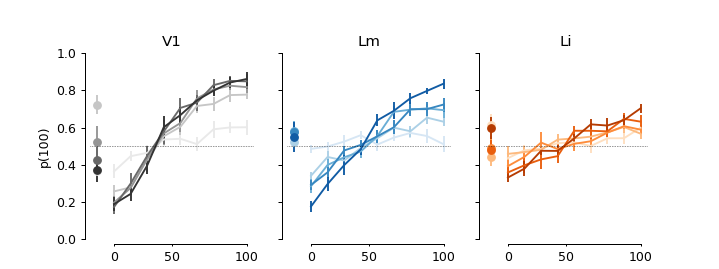

In [62]:
fig, axes = pl.subplots(1, 3, sharex=True, sharey=True, figsize=(8,3))
for ax, visual_area in zip(axes, visual_areas):
    arr = np.mean(pchoose_grp[visual_area], axis=-1)
    arr_sem = spstats.sem(pchoose_grp[visual_area], axis=-1)

    if visual_area=='V1':
        size_colors = sns.color_palette("Greys", len(tested_sizes))
    elif visual_area == 'Lm':
        size_colors = sns.color_palette("Blues", len(tested_sizes))
    else:
        size_colors = sns.color_palette("Oranges", len(tested_sizes))

    for si, sz in enumerate(tested_sizes):
        curr_color = size_colors[si]
        # plot control
        ax.plot(0, arr[si, 0], color=curr_color, marker='o')
        ax.errorbar(0, arr[si, 0],\
                        yerr=arr_sem[si, 0], fmt='none',
                        ecolor=curr_color)

        ax.plot(np.arange(1, len(tested_morphs)), arr[si, 1:], color=curr_color)
        ax.errorbar(np.arange(1, len(tested_morphs)), arr[si, 1:],\
                        yerr=arr_sem[si, 1:], fmt='none',
                        ecolor=curr_color)
    
    ax.set_ylim([0, 1])
    ax.set_title(visual_area)
    

for ai, ax in enumerate(axes):
    midp = (len(tested_morphs)-1)/2.
    ax.set_xticks([1, midp, len(tested_morphs)-1]) #range(len(tested_morphs)))
    ax.set_xticklabels([0, 50, 100])
    sns.despine(trim=True, offset=4)
    ax.axhline(y=0.5, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=2)
    if ai==0:
        ax.set_ylabel('p(100)')
        
pl.subplots_adjust(top=0.8)

pl.savefig(os.path.join(outdir, 'avg-pChoose100-LOO_by-visual-area-colors.svg'))

In [158]:
(len(tested_morphs)-1)/2.

4.5

In [93]:
choice_vals=dict((sz, []) for sz, gg in g.groupby(['size']))
for sz, gg in g.groupby(['size']):
    choice_vals[sz].append(gg['mean'].values)
    


In [94]:
choice_vals

{10: [array([0.4334126 , 0.31034483, 0.55350773, 0.65933413, 0.71284185,
         0.69976219, 0.65814507, 0.83115339, 0.68073722, 0.62068966])],
 20: [array([0.84661118, 0.27586207, 0.15398335, 0.23543401, 0.50237812,
         0.52615933, 0.77110583, 0.54577883, 0.61058264, 0.72413793])],
 30: [array([0.99940547, 0.17241379, 0.41022592, 0.6783591 , 0.78299643,
         0.82818074, 0.91914388, 0.75624257, 0.84185493, 0.93103448])],
 40: [array([0.63258026, 0.17241379, 0.28061831, 0.51426873, 0.6646849 ,
         0.89476813, 0.92627824, 0.93043995, 0.86206897, 0.89655172])],
 50: [array([0.26337693, 0.13793103, 0.17241379, 0.41498216, 0.67895363,
         0.73900119, 0.79785969, 0.7568371 , 0.79548157, 0.86206897])]}

In [97]:
np.array([gg['mean'].values for sz, gg in g.groupby(['size'])]).shape

(5, 10)

In [164]:
with open(os.path.join(outdir, 'pChoose100_results.pkl'), 'wb') as f:
    pkl.dump(probs, f, protocol=pkl.HIGHEST_PROTOCOL)